## Jupyter Notebook destiné à extraire des données climatiques  
#### Données ERA5 de l'ECMWF exploitées à l'aide du module xarray
Source: https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&text=ERA5  
Source: https://docs.xarray.dev/en/stable/index.html  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import geopandas as gpd
import rasterio
import os
import netCDF4 as nc4
from get_temp_era5 import download_era5_temperature_data
from get_osmose_data import get_heating_coeff_ts
import plotly.graph_objects as go
import functions_thermosensitive_min_method

## 0) Récupérer les données pour un pays et une année
On peut sauter cette partie si on a déjà des netCDF de température

### A) Utiliser l'API : choix du pays et d'une année (autre que 2021)
Décommenter la dernière ligne pour lancer le téléchargement. Il prend environ 30 minutes pour un pays et une année au pas de temps horaire.

In [2]:
# Load country boundaries using Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Exclure les DOM-TOM de France
world = world[~world.name.isin(['Guadeloupe', 'Martinique', 'French Guiana', 'Réunion', 'Mayotte', 'Saint Pierre and Miquelon'])]

# Select the desired country (e.g., France)
country_name = 'Spain'
country_polygon = world[world.name == country_name].geometry.squeeze()

# Extract bounding box coordinates from the country polygon
xmin, ymin, xmax, ymax = country_polygon.bounds

# Define the bounding box for the selected country
country_bounding_box = [ymax, xmin, ymin, xmax]  # [north, west, south, east]

start_year = 2016
end_year = 2016 #on peut télécharger plusieurs années d'un coup mais pas besoin ici

# download_era5_temperature_data(country_bounding_box, country_name, start_year, end_year)


C:\Users\JD278300\AppData\Local\Temp\ipykernel_3236\4162879607.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


### B) Charger les données pour le monde entier pour 2021 (téléchargées en amont)
Pour les télécharger : https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

In [2]:
nc = nc4.Dataset('era5_world_t2m_2021.nc', mode='r')  # 
dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

<Axes: >

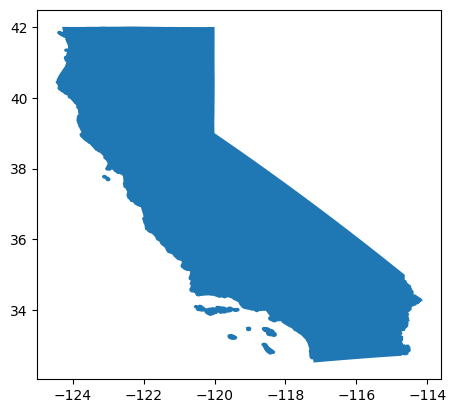

In [3]:
# Cas spécifique pour les états des US -- à compléter 
country_name = 'California'
california = gpd.read_file(f"country_masks/{country_name}.shp")
country_polygon = california.geometry.iloc[0]

# Extract bounding box coordinates from the country polygon
xmin, ymin, xmax, ymax = country_polygon.bounds

# Define the bounding box for the selected country
country_bounding_box = [ymax, xmin, ymin, xmax]  # [north, west, south, east]
california.plot()

In [4]:
# Load country boundaries using Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Exclure les DOM-TOM de France, pas forcément utile
world = world[~world.name.isin(['Guadeloupe', 'Martinique', 'French Guiana', 'Réunion', 'Mayotte', 'Saint Pierre and Miquelon'])]

# Select the desired country (e.g., France)
country_name = 'France'
country_polygon = world[world.name == country_name].geometry.squeeze()

# Extract bounding box coordinates from the country polygon
xmin, ymin, xmax, ymax = country_polygon.bounds

# Define the bounding box for the selected country
country_bounding_box = [ymax, xmin, ymin, xmax]  # [north, west, south, east]
print(country_bounding_box)


C:\Users\JD278300\AppData\Local\Temp\ipykernel_32748\3384893515.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


[51.14850617126183, -54.524754197799716, 2.0533891870159806, 9.560016310269134]


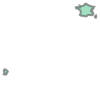

In [5]:
country_polygon

Il faut récupérer les coordonnées de la boîte dans laquelle le pays se trouve pour pouvoir filtrer le dataset du monde. Il y a des problèmes car les bounding box vont de -180 à 180 alors que le dataset a des coordonnées de 0 à 360. On essaie de régler le problème dans la cellule en-dessous. 

In [6]:


# Définir les bounding boxes pour le pays d'intérêt 
bbox_country = {
    'latitude': [country_bounding_box[2], country_bounding_box[0]],  # Latitude (min, max)
    'longitude': [country_bounding_box[1], country_bounding_box[3]]  # Longitude (min, max)
}

print(bbox_country)
# Si les longitudes vont de -180 à 180, ajustez les valeurs des bounding boxes
if bbox_country['longitude'][0] < 0:
    bbox_country['longitude'][0] += 360
    if bbox_country['longitude'][1] < 0:
        bbox_country['longitude'][1] += 360
        lon_indices = (dataset.longitude >= bbox_country['longitude'][0]) & (dataset.longitude <= bbox_country['longitude'][1])
        
    else :
        lon_indices = (dataset.longitude >= bbox_country['longitude'][0]) | (dataset.longitude <= bbox_country['longitude'][1])

else : 
    lon_indices = (dataset.longitude >= bbox_country['longitude'][0]) & (dataset.longitude <= bbox_country['longitude'][1])

print(lon_indices)

lat_indices = (dataset.latitude >= bbox_country['latitude'][0]) & (dataset.latitude <= bbox_country['latitude'][1])

# Extraire les données de température de l'air (t2m) en utilisant les bounding boxes
t2m_country= dataset.sel(latitude=lat_indices, longitude=lon_indices)
print(t2m_country)
# Vérifier si les longitudes nécessitent une transformation inverse
if t2m_country.longitude.max() > 180:
    # print('before')

    # Soustraire 360 degrés des longitudes supérieures à 180
    t2m_country['longitude'] = (t2m_country.longitude - 360)

    t2m_country = t2m_country.assign_coords(longitude=t2m_country['longitude'])

t2m_country = t2m_country.sortby('longitude')

# On sauvergarde le fichier de température dans un netCDF4
t2m_country.to_netcdf(f'era5_temperature_{country_name}_{start_year}_{end_year}.nc')

{'latitude': [2.0533891870159806, 51.14850617126183], 'longitude': [-54.524754197799716, 9.560016310269134]}
<xarray.DataArray 'longitude' (longitude: 1440)> Size: 1kB
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 257, latitude: 196, time: 8760)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 784B 51.0 50.75 50.5 50.25 ... 2.75 2.5 2.25
  * time       (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 2GB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-26 09:58:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


: 

: 

In [127]:
t2m_country.longitude

<xarray.DataArray 'longitude' (longitude: 13)> Size: 52B
array([126.25, 126.5 , 126.75, 127.  , 127.25, 127.5 , 127.75, 128.  , 128.25,
       128.5 , 128.75, 129.  , 129.25], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 52B 126.2 126.5 126.8 ... 128.8 129.0 129.2
Attributes:
    units:      degrees_east
    long_name:  longitude

In [6]:

start_year = 2021
end_year = 2021
dataset_country =  xr.open_dataset(f'era5_temperature_{country_name}_{start_year}_{end_year}.nc')

In [7]:
dataset_country

<xarray.Dataset> Size: 103MB
Dimensions:    (longitude: 65, latitude: 45, time: 8760)
Coordinates:
  * longitude  (longitude) float32 260B -6.0 -5.75 -5.5 -5.25 ... 9.5 9.75 10.0
  * latitude   (latitude) float32 180B 52.0 51.75 51.5 51.25 ... 41.5 41.25 41.0
  * time       (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 102MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-09 10:20:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## 1) Prise en main des données 

In [8]:
# Ouverture du fichier NetCdf
# nc = nc4.Dataset(f'era5_temperature_{country_name}_{start_year}_{end_year}.nc', mode='r')  # Or from siphon.ncss
# dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))
# ds = dataset
# dataset = xr.open_dataset('era5_temperature_France_2023_2023.nc') Pour une rason non expliquée, cette commande ne marche plus le 29.03.2024

In [9]:
nc = nc4.Dataset(f'era5_temperature_{country_name}_{start_year}_{end_year}.nc', mode='r')  # 
dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

In [10]:
# dataset_country = xr.open_dataset('era5_temperature_Spain_2016_2016.nc')
# dataset_country =  xr.open_dataset(f'era5_temperature_{country_name}.nc')

### 1A) Création d'un mask à partir du polygon récupéré sur geopandas

In [11]:
# Création du mask à partir du polygone
gdf = gpd.GeoDataFrame(geometry=[country_polygon])

isExist = os.path.exists('country_masks')
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs('country_masks')
   print("The new directory is created!")

output_shapefile = f"country_masks/{country_name}.shp"

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_shapefile)


<Axes: >

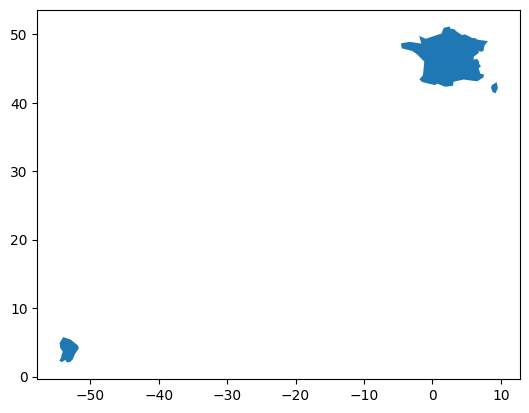

In [12]:
# Recuperation frontières
pays=gpd.read_file(output_shapefile)
pays.plot()

**Mise en place d'un mask uniquement pour la France**  
Sources:
https://stackoverflow.com/questions/51398563/python-mask-netcdf-data-using-shapefile  
https://github.com/pydata/xarray/issues/501

US states bounding boxes : https://observablehq.com/@rdmurphy/u-s-state-bounding-boxes

### 1B) Calquer le masque sur le netCDF

In [13]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')

    return xr_da

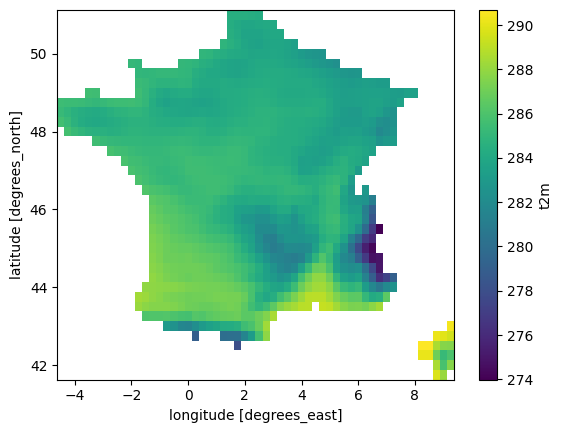

In [14]:
data = add_shape_coord_from_data_array(dataset_country, f'country_masks/{country_name}.shp', "pays")
# data = add_shape_coord_from_data_array(dataset, 'country_masks/mask_france.shp', "pays")
data_country = data.where(data.pays==0, drop =True)
data_country.t2m.mean(dim="time").plot()
#data_france

## 2) Extraction de la température moyenne horaire

In [15]:
# Mise en place du calcul de la moyenne sur le territoire pour chaque pas de temps horaire
tab = np.zeros(8760)
for i in range (8760):
    tab[i] = (data_country.isel(time=i).t2m.mean(['latitude','longitude'])- 273.15)

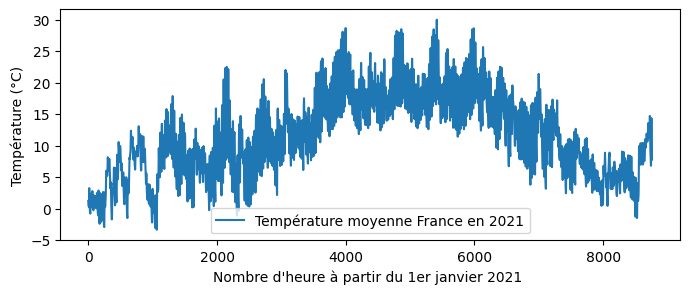

In [16]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(8760),tab ,label=f'Température moyenne {country_name} en {start_year}')
plt.xlabel(f"Nombre d'heure à partir du 1er janvier {start_year} ")
plt.ylabel("Température (°C)")
plt.legend()
plt.show()

In [17]:
# Sauvegarde/export des données
np.savetxt(f'temp_moy_{country_name}_{start_year}_{end_year}.txt', tab)

In [18]:
#vérification que les deux jeux de données sont les mêmes
# local_download = pd.read_csv('temp_moy_Greece_2021.txt')
# world_download = pd.read_csv('temp_moy_Greece_2021_v2.txt')
# plt.plot(local_download, label = 'local')
# plt.plot(world_download, label = 'world')
# plt.show()

## 4) Plot température et heating coeff pour la même année

In [28]:
heat_coeff_country = get_heating_coeff_ts('ES',2016)
#cette fonction se trouve dans le fichier python get_osmose_data.py

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=heat_coeff_country.index, y=tab , mode='lines', name=f'Temperature in {country_name}'))
fig.add_trace(go.Scatter(x=heat_coeff_country.index, y=heat_coeff_country, mode='lines', name=f'Heating coefficient {country_name}', yaxis='y2'))

# Update layout for secondary y-axis
fig.update_layout(yaxis2=dict(title='Heating coefficient', overlaying='y', side='right'))
fig.update_layout(title=f'{country_name} {start_year}',
                  xaxis_title='Date',
                  yaxis_title='Temperature °C')

fig.show()

On peut calculer la corrélation heating coefficient/temperature

In [ ]:
from scipy.optimize import curve_fit
import numpy as np 
temperatures = np.array(tab)
heat_coefficient = np.array(heat_coeff_country)
# Define piecewise linear function
def piecewise_linear_regression(temperatures, electricity_consumption):
    # Fit linear regression for temperatures below 18°C
    indices_below_18 = temperatures < 18
    X_below_18 = temperatures[indices_below_18]
    y_below_18 = electricity_consumption[indices_below_18]
    coefficients_below_18 = np.polyfit(X_below_18, y_below_18, 1)

    # Fit linear regression for temperatures above 22°C
    indices_above_22 = temperatures > 22
    X_above_22 = temperatures[indices_above_22]
    y_above_22 = electricity_consumption[indices_above_22]
    coefficients_above_22 = np.polyfit(X_above_22, y_above_22, 1)

    return coefficients_below_18, coefficients_above_22

# Apply piecewise linear regression
coefficients_below_18, coefficients_above_22 = piecewise_linear_regression(temperatures, heat_coefficient)

# Print coefficients
print("Coefficients for temperatures below 18°C (slope, intercept):", coefficients_below_18)
print("Coefficients for temperatures above 22°C (slope, intercept):", coefficients_above_22)

NameError: name 'heat_coeff_country' is not defined

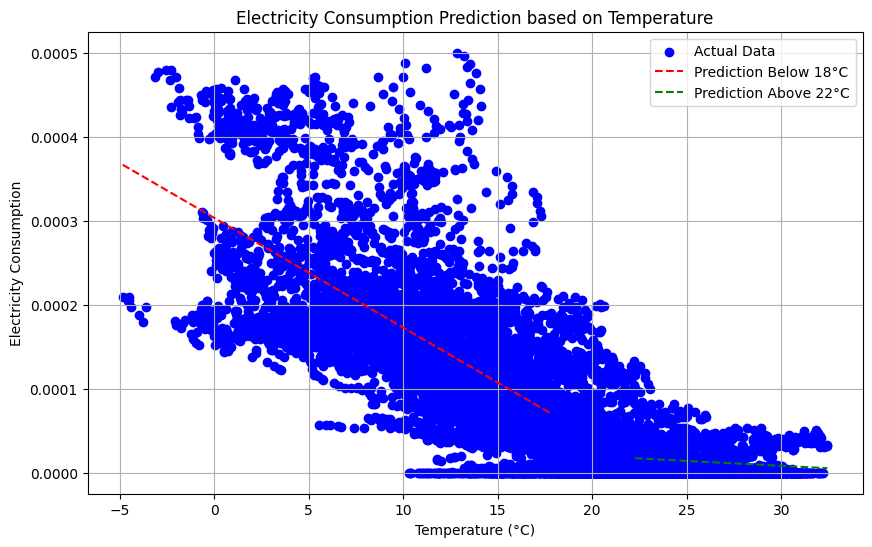

In [ ]:
# Generate temperatures for plotting
temperatures_plot = np.linspace(min(temperatures), max(temperatures), 100)

# Predict electricity consumption based on temperature
# Predict electricity consumption based on temperature
predicted_consumption_below_18 = coefficients_below_18[0] * temperatures_plot + coefficients_below_18[1]
predicted_consumption_below_18[temperatures_plot >= 18] = None

predicted_consumption_above_22 = coefficients_above_22[0] * temperatures_plot + coefficients_above_22[1]
predicted_consumption_above_22[temperatures_plot <= 22] = None

# Plot the data and predictions
plt.figure(figsize=(10, 6))
plt.scatter(temperatures, heat_coefficient, color='blue', label='Actual Data')
plt.plot(temperatures_plot, predicted_consumption_below_18, color='red', linestyle='--', label='Prediction Below 18°C')
plt.plot(temperatures_plot, predicted_consumption_above_22, color='green', linestyle='--', label='Prediction Above 22°C')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Prediction based on Temperature')
plt.legend()
plt.grid(True)
plt.show()

### 5) Méthode de la load minimale pour extraire la part thermosensible

Source : appendix de https://pastel.hal.science/tel-01142341/document

#### 5a) Vérification que ça fonctionne avec les données de RTE sur l'hiver 2019-2020
Cette partie est spécifique RTE. Ne devrait plus être utile pour la suite.

In [ ]:
_#Récupérer la série temporelle de température
temp = np.loadtxt('temp_moy_FR19_20.txt')
conso = np.loadtxt('conso_elec_2019.txt')
therm_RTE = np.loadtxt('part_thermo_RTE_19_20.txt')


In [ ]:
conso_ts = pd.DataFrame(conso)

In [ ]:
#fonction modifiée pour qu'elle démarre au 1er octobre comme dans les séries dispos de RTE pour la part thermosensible
def charge_min(time_series, year): #récupère tous les minimums des couples (jour, heure) d'une time series
    charge_min = pd.DataFrame()
    first_january = pd.Timestamp(year=year, month=1, day=1)

    index = pd.date_range(start=first_january, periods=len(time_series), freq='h')
    time_series.index = index
    min_by_day_hour = time_series.groupby([time_series.index.dayofweek, time_series.index.hour]).min()

    return min_by_day_hour

In [ ]:
def weighted_mean(ts):
      ## Mise en place d'une moyenne glissante sur la journée non pondérée pour les données de fit du modèle
    rolling_window = ts.rolling(window=24)
    weight = pd.Series(range(1,25))
    # weighted_mean = rolling_window.apply(lambda x: (x*weight).sum()/weight.sum(), raw=True)
    w_mean = rolling_window.mean()
    w_mean=w_mean.fillna(ts)
    return w_mean

In [ ]:
ts_weighted =weighted_mean(conso_ts)
# start = pd.Timestamp(year=2019, month=10, day=1)
time_series_min = charge_min(ts_weighted, 2019)

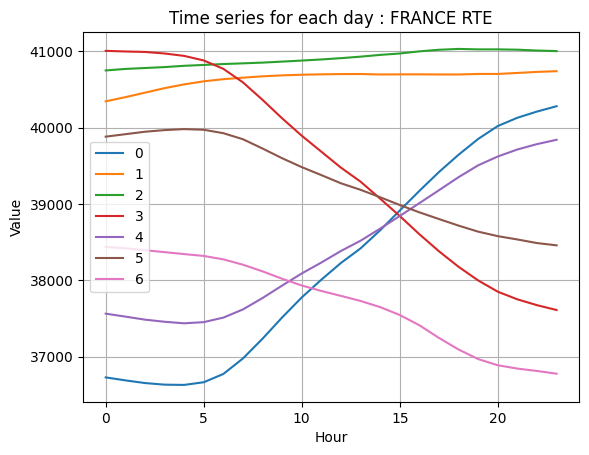

In [ ]:
groups = time_series_min.groupby(level=0)

# Create a plot for each group
for name, group in groups:
    plt.plot(group.index.get_level_values(1), group.values, label=name)

# Configure the plot
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Time series for each day : FRANCE RTE')
plt.legend()
plt.grid(True)
plt.show()

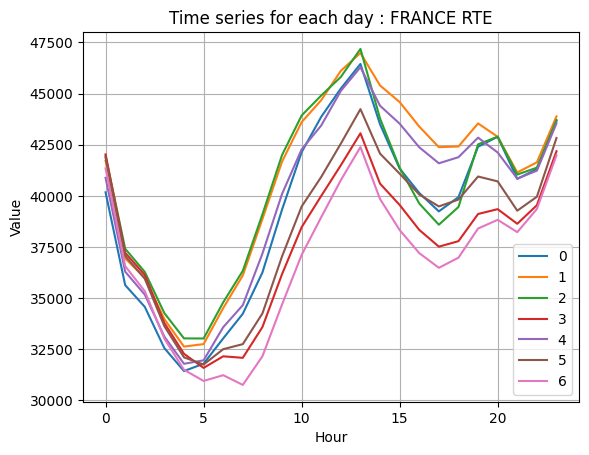

In [ ]:
time_series_min = charge_min(conso_ts, 2019)
groups = time_series_min.groupby(level=0)

# Create a plot for each group
for name, group in groups:
    plt.plot(group.index.get_level_values(1), group.values, label=name)

# Configure the plot
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Time series for each day : FRANCE RTE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
therm_ts = conso_ts.copy()
for item in therm_ts.index:
        therm_ts.loc[item,:] -= time_series_min.loc[(item.dayofweek, item.hour),:]


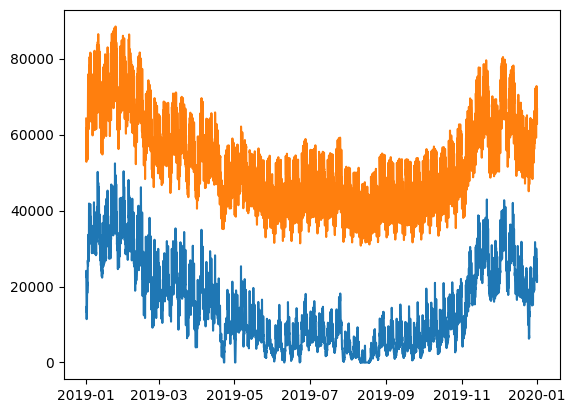

In [ ]:
plt.plot(therm_ts, label='part thermosensible')
plt.plot(conso_ts, label = 'total')
plt.legend()
plt.show()

On compare avec la part donnée par RTE

In [ ]:
# Extrait les données d'octobre à décembre
oct_dec_data = conso_ts['2019-10-01':'2019-12-31']

# Extrait les données de janvier à mars
jan_mar_data = conso_ts['2019-01-01':'2019-03-31']

new_df_conso = pd.concat([oct_dec_data, jan_mar_data])

In [ ]:
part_RTE = pd.read_csv('part_thermo_RTE_19_20.txt',  header = None)
part_RTE.index =  new_df_conso.index
therm_RTE = part_RTE*1000

In [ ]:
# Extrait les données d'octobre à décembre
oct_dec_data = therm_ts['2019-10-01':'2019-12-31']

# Extrait les données de janvier à mars
jan_mar_data = therm_ts['2019-01-01':'2019-03-31']

new_df_therm = pd.concat([oct_dec_data, jan_mar_data])

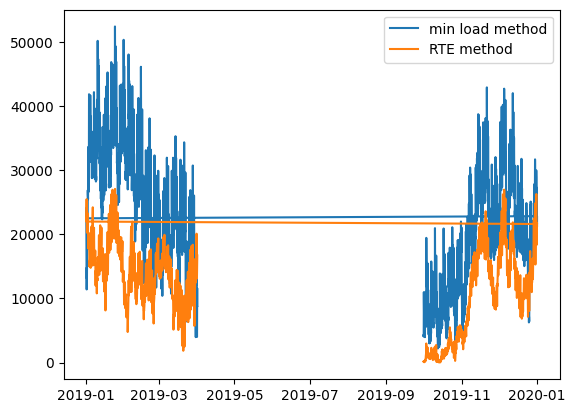

In [ ]:
plt.plot(new_df_therm, label = 'min load method')
plt.plot(therm_RTE, label = 'RTE method')
plt.legend()
plt.show()

#### b) Application ailleurs 

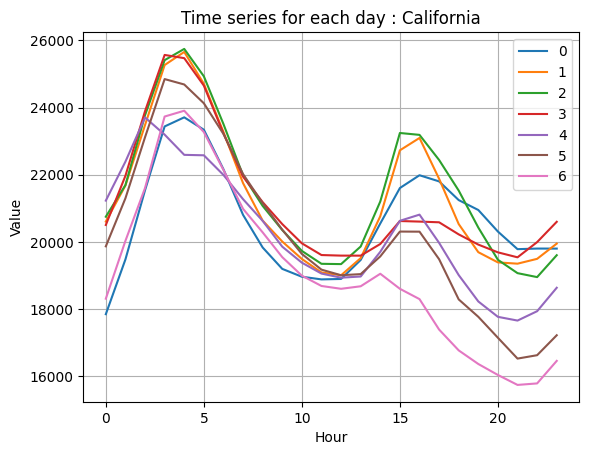

In [159]:
time_series = charge_min(conso_ts, 2021)

groups = time_series.groupby(level=0)

# Create a plot for each group
for name, group in groups:
    plt.plot(group.index.get_level_values(1), group.values, label=name)

# Configure the plot
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title(f'Time series for each day : {country_name}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from functions_thermosensitive_min_method import thermosensitive_ts, piecewise_linear_regression, charge_min
import pandas as pd

#chemin d'accès aux time series de consomamtion
conso_path = '../input_time_series/'
# conso_file_name = 'Greece/Greece_load_entsoe_2021.xlsx'
conso_file_name='California/California_2021_hourly_demand_MWh.xlsx'
conso_ts = pd.read_excel(conso_path+conso_file_name)

#Extraction de la part thermosensible avec la méthode de la load min
therm_ts = thermosensitive_ts(conso_ts, 2021)



Régressions par morceaux

In [162]:
temperatures = np.loadtxt(f'temp_moy_{country_name}_{start_year}_{end_year}.txt')
# Apply piecewise linear regression
coefficients_below_18, coefficients_above_22 = piecewise_linear_regression(temperatures, therm_ts)
print("Coefficients for temperatures below 18°C (slope, intercept):", coefficients_below_18)
print("Coefficients for temperatures above 22°C (slope, intercept):", coefficients_above_22)

Coefficients for temperatures below 18°C (slope, intercept): [[  27.52381969]
 [1959.30023036]]
Coefficients for temperatures above 22°C (slope, intercept): [[  1012.1341876 ]
 [-17331.86575206]]


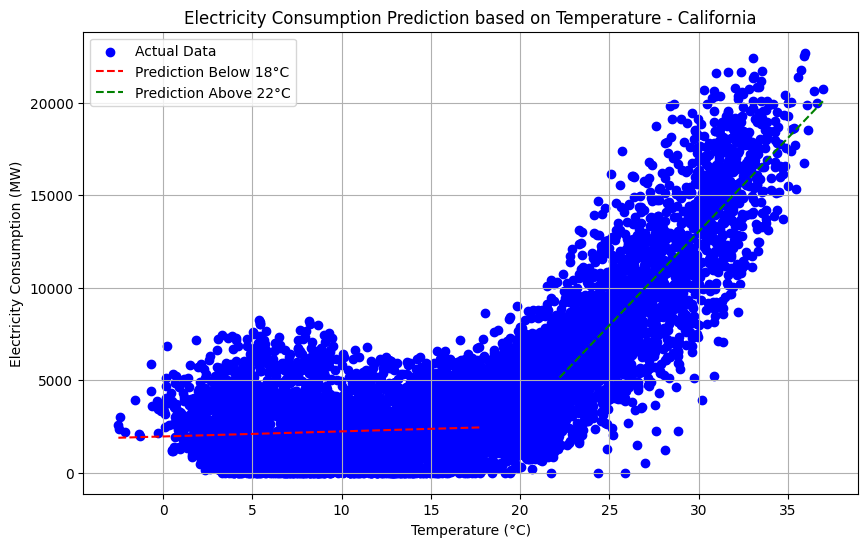

In [163]:
plot_regression(temperatures, therm_ts, coefficients_below_18, coefficients_above_22)

Coefficients for temperatures below 18°C (slope, intercept): [[ -47.56843665]
 [5981.14256406]]
Coefficients for temperatures above 22°C (slope, intercept): [[ 287.33659867]
 [-559.25821264]]


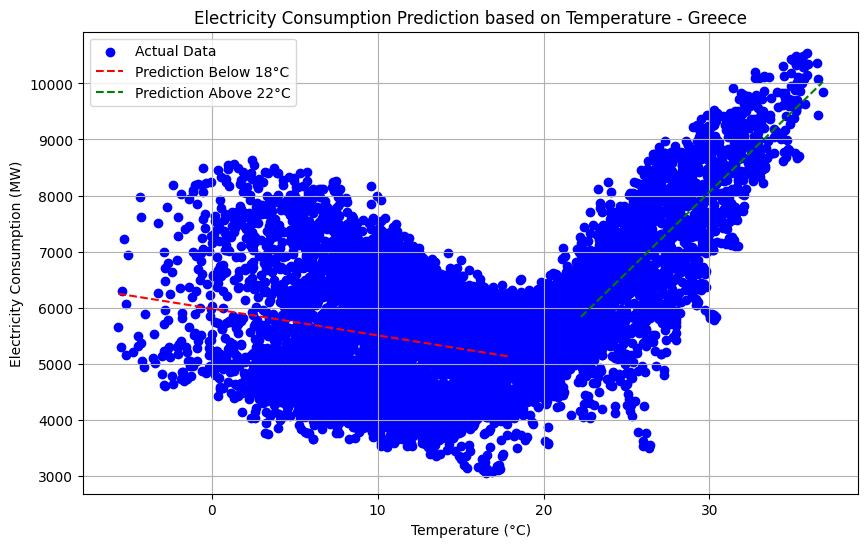

In [50]:
from functions_thermosensitive_min_method import thermosensitive_ts
import pandas as pd
conso_path = '../input_time_series/'
conso_file_name = 'Greece/Greece_load_entsoe_2021.xlsx'
# conso_file_name='Korea_load_2015.xlsx'
conso_ts = pd.read_excel(conso_path+conso_file_name)
therm_ts = thermosensitive_ts(conso_ts, 2021)


temperatures = np.loadtxt('temp_moy_Greece_2021.txt')

# Apply piecewise linear regression
coefficients_below_18, coefficients_above_22 = piecewise_linear_regression(temperatures, conso_ts)
print("Coefficients for temperatures below 18°C (slope, intercept):", coefficients_below_18)
print("Coefficients for temperatures above 22°C (slope, intercept):", coefficients_above_22)
plot_regression(temperatures, therm_ts, coefficients_below_18, coefficients_above_22)

Coefficients for temperatures below 18°C (slope, intercept): [[ -102.09909471]
 [28389.07269727]]
Coefficients for temperatures above 22°C (slope, intercept): [[  328.21468506]
 [21731.70942193]]


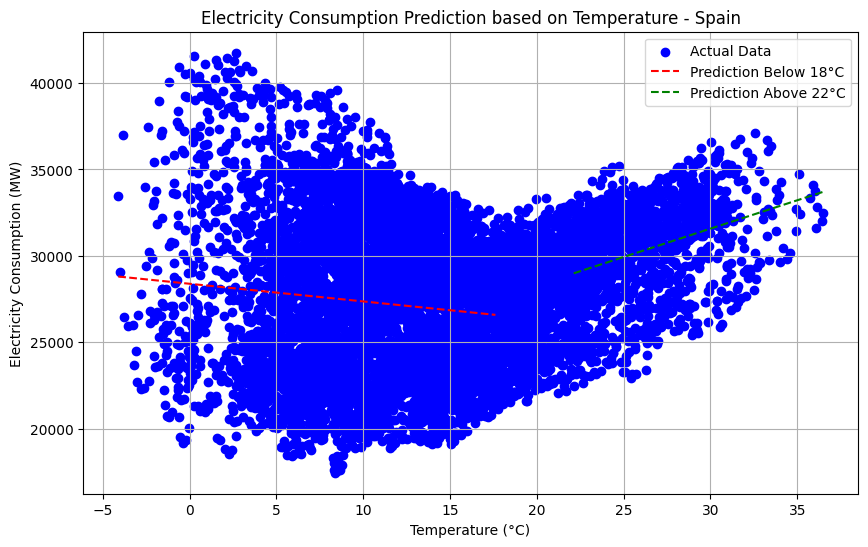

In [66]:
from functions_thermosensitive_min_method import thermosensitive_ts
import pandas as pd
conso_path = '../input_time_series/'
conso_file_name = 'Spain/Espagne_load_entsoe_2021.xlsx'
# conso_file_name='Korea_load_2015.xlsx'
conso_ts = pd.read_excel(conso_path+conso_file_name)
therm_ts = thermosensitive_ts(conso_ts, 2021)


temperatures = np.loadtxt('temp_moy_Spain_2021.txt')

# Apply piecewise linear regression
coefficients_below_18, coefficients_above_22 = piecewise_linear_regression(temperatures, conso_ts)
print("Coefficients for temperatures below 18°C (slope, intercept):", coefficients_below_18)
print("Coefficients for temperatures above 22°C (slope, intercept):", coefficients_above_22)

plot_regression(temperatures, therm_ts, coefficients_below_18, coefficients_above_22)